# Lead-Time Probabilistic Modeling for Semiconductor Supply Chain

This notebook demonstrates how to:
1. Build a clean historical lead-time dataset
2. Fit multiple probability distributions (Normal, Lognormal, Gamma, Weibull)
3. Select the best distribution by AIC
4. Compute risk metrics such as:
   - P(Lead time > x weeks)
   - Expected lead time
   - Safety stock buffer for a target service level
5. Run a Monte Carlo simulation of lead-time uncertainty
6. Produce inputs that can feed into an optimization layer.

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
## Build historical lead-time dataset (simulated example)
np.random.seed(42)

# Simulate 200 weekly purchase orders
df = pd.DataFrame({'po_date': pd.date_range('2023-01-01', periods=200, freq='W')})

# Synthetic receipt dates: mean 16 weeks, std dev 3 weeks (clipped at 6 weeks minimum)
raw_lt = np.random.normal(loc=16, scale=3, size=len(df))
raw_lt = np.clip(raw_lt, 6, None)
df['receipt_date'] = df['po_date'] + pd.to_timedelta(raw_lt, unit='W')

df['lead_time_weeks'] = (df['receipt_date'] - df['po_date']).dt.days / 7
df[['po_date', 'receipt_date', 'lead_time_weeks']].head()

,po_date,receipt_date,lead_time_weeks
0,2023-01-01,2023-05-03 10:20:38.159223581,17.428571
1,2023-01-08,2023-04-27 02:18:53.251955004,15.571429
2,2023-01-15,2023-05-20 14:26:06.083529898,17.857143
3,2023-01-22,2023-06-14 23:36:25.371466723,20.428571
4,2023-01-29,2023-05-16 01:59:12.116901977,15.285714


In [ ]:
## Outlier filtering / basic cleaning
lt = df['lead_time_weeks']
mu, sigma = lt.mean(), lt.std()
lower, upper = mu - 3*sigma, mu + 3*sigma
mask = lt.between(lower, upper)
df_clean = df[mask].copy()
lead_times = df_clean['lead_time_weeks'].values
print(f'Original points: {len(df)}, after filtering: {len(df_clean)}')

Original points: 200, after filtering: 200


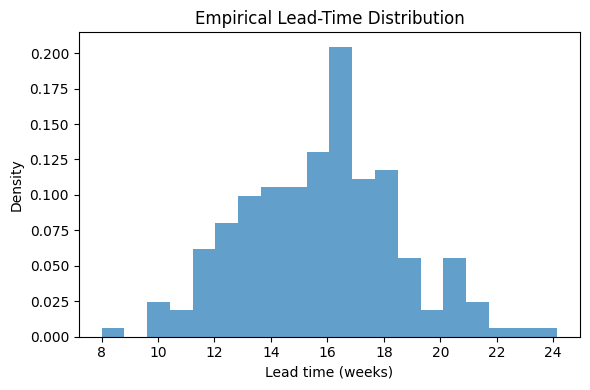

In [ ]:
## Visualize empirical lead-time distribution
plt.figure(figsize=(6,4))
plt.hist(lead_times, bins=20, density=True, alpha=0.7)
plt.xlabel('Lead time (weeks)')
plt.ylabel('Density')
plt.title('Empirical Lead-Time Distribution')
plt.tight_layout()
plt.show()

In [ ]:
## Fit candidate probability distributions using MLE
candidate_distributions = {
    'normal': stats.norm,
    'lognormal': stats.lognorm,
    'gamma': stats.gamma,
    'weibull': stats.weibull_min,
}
fit_results = {}

for name, dist in candidate_distributions.items():
    try:
        params = dist.fit(lead_times)
        log_likelihood = np.sum(dist.logpdf(lead_times, *params))
        k = len(params)
        aic = 2*k - 2*log_likelihood
        fit_results[name] = {'params': params, 'aic': aic}
    except Exception as e:
        print(f'Could not fit {name}: {e}')

fit_results

{'normal': {'params': (np.float64(15.80642857142857),
   np.float64(2.7882368615163178)),
  'aic': np.float64(981.7391919986128)},
 'lognormal': {'params': (np.float64(0.0420488264386057),
   -50.475590426201975,
   np.float64(66.22344885970895)),
  'aic': np.float64(983.2197376582451)},
 'gamma': {'params': (np.float64(249.0470000475583),
   np.float64(-28.1968734546238),
   np.float64(0.17668674272662613)),
  'aic': np.float64(983.2170248189918)},
 'weibull': {'params': (np.float64(3.484639910335588),
   np.float64(6.911352374565075),
   np.float64(9.87838317207981)),
  'aic': np.float64(984.5486040808526)}}

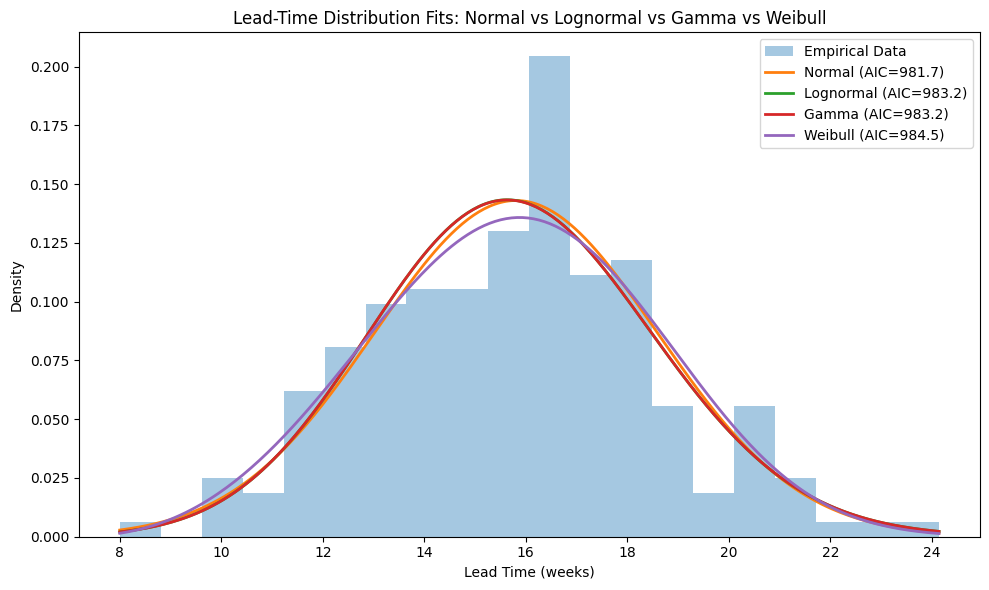

AIC Ranking (lower = better):
Normal: AIC = 981.74
Gamma: AIC = 983.22
Lognormal: AIC = 983.22
Weibull: AIC = 984.55


In [ ]:
'''
lead_times 
'''
data = lead_times  

# Candidate distributions
distributions = {
    "Normal": stats.norm,
    "Lognormal": stats.lognorm,
    "Gamma": stats.gamma,
    "Weibull": stats.weibull_min
}

fit_info = {}

# Fit each distribution & compute AIC
for name, dist in distributions.items():
    params = dist.fit(data)
    ll = np.sum(dist.logpdf(data, *params))  # log-likelihood
    k = len(params)
    aic = 2*k - 2*ll
    fit_info[name] = {"params": params, "aic": aic}

# Build x-axis
x = np.linspace(min(data), max(data), 300)

# Plot empirical data
plt.figure(figsize=(10, 6))
plt.hist(data, bins=20, density=True, alpha=0.4, label="Empirical Data")

# Plot each distribution PDF with AIC in legend
for name, dist in distributions.items():
    params = fit_info[name]["params"]
    pdf = dist.pdf(x, *params)

    aic = fit_info[name]["aic"]
    label = f"{name} (AIC={aic:.1f})"

    plt.plot(x, pdf, linewidth=2, label=label)

plt.xlabel("Lead Time (weeks)")
plt.ylabel("Density")
plt.title("Lead-Time Distribution Fits: Normal vs Lognormal vs Gamma vs Weibull")
plt.legend()
plt.tight_layout()
plt.show()

# AIC rankings
sorted_AIC = sorted(fit_info.items(), key=lambda x: x[1]['aic'])
print("AIC Ranking (lower = better):")
for name, info in sorted_AIC:
    print(f"{name}: AIC = {info['aic']:.2f}")


Best-fit distribution: normal
Parameters: (np.float64(15.80642857142857), np.float64(2.7882368615163178))


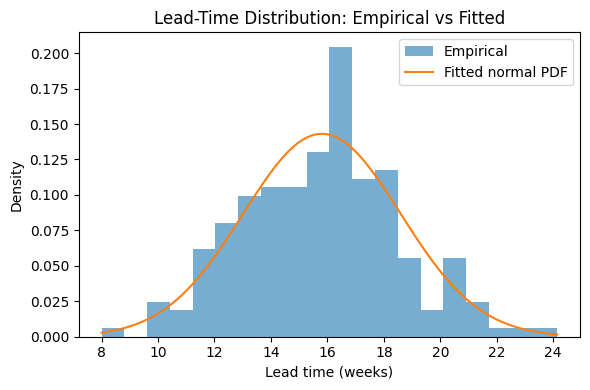

In [ ]:
## Select best distribution by AIC and overlay PDF
best_name, best_info = min(fit_results.items(), key=lambda x: x[1]['aic'])
best_params = best_info['params']
print('Best-fit distribution:', best_name)
print('Parameters:', best_params)

best_dist = candidate_distributions[best_name]
x = np.linspace(lead_times.min(), lead_times.max(), 200)
pdf = best_dist.pdf(x, *best_params)

plt.figure(figsize=(6,4))
plt.hist(lead_times, bins=20, density=True, alpha=0.6, label='Empirical')
plt.plot(x, pdf, label=f'Fitted {best_name} PDF')
plt.xlabel('Lead time (weeks)')
plt.ylabel('Density')
plt.title('Lead-Time Distribution: Empirical vs Fitted')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
## Compute risk metrics
threshold = 20  # weeks
p_gt = 1 - best_dist.cdf(threshold, *best_params)
expected_lt = best_dist.mean(*best_params)
std_lt = best_dist.std(*best_params)
service_level = 0.95
safety_buffer = best_dist.ppf(service_level, *best_params)

print(f'P(Lead time > {threshold} weeks) = {p_gt:.3f}')
print(f'Expected lead time = {expected_lt:.2f} weeks')
print(f'Standard deviation of lead time = {std_lt:.2f} weeks')
print(f'95% service-level lead-time buffer = {safety_buffer:.2f} weeks')

P(Lead time > 20 weeks) = 0.066
Expected lead time = 15.81 weeks
Standard deviation of lead time = 2.79 weeks
95% service-level lead-time buffer = 20.39 weeks


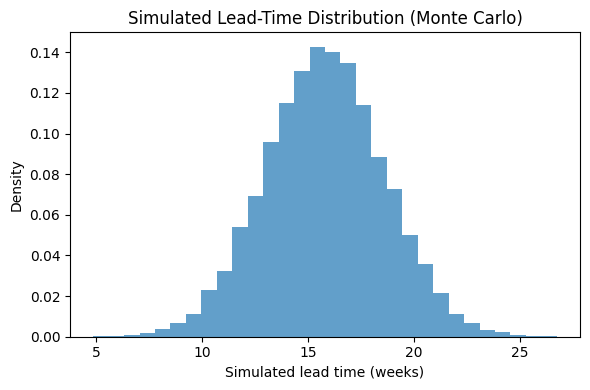

In [ ]:
## Monte Carlo simulation of lead times
n_runs = 10000
simulated_lead_times = best_dist.rvs(*best_params, size=n_runs)
simulated_lead_times = np.clip(simulated_lead_times, 0, None)

plt.figure(figsize=(6,4))
plt.hist(simulated_lead_times, bins=30, density=True, alpha=0.7)
plt.xlabel('Simulated lead time (weeks)')
plt.ylabel('Density')
plt.title('Simulated Lead-Time Distribution (Monte Carlo)')
plt.tight_layout()
plt.show()

In [ ]:
## Package values as inputs to an optimization layer
optimization_inputs = {
    'best_distribution': best_name,
    'params': best_params,
    'mean_lt': float(expected_lt),
    'std_lt': float(std_lt),
    'p95_lt': float(best_dist.ppf(0.95, *best_params)),
    'p975_lt': float(best_dist.ppf(0.975, *best_params)),
}
optimization_inputs

{'best_distribution': 'normal',
 'params': (np.float64(15.80642857142857), np.float64(2.7882368615163178)),
 'mean_lt': 15.80642857142857,
 'std_lt': 2.7882368615163178,
 'p95_lt': 20.392670085893474,
 'p975_lt': 21.271272400367547}